# APLICACIONES DE CIENCIAS DE LA COMPUTACIÓN (INF265)
## (2023-2)

## Laboratorio 1: Agentes Inteligentes

Indicaciones generales:

- Duración: **120 minutos (2 horas)**.
- **Las respuestas deben contar con un buen fundamento teórico**, se realizarán descuentos en el puntaje a respuestas que no contesten a lo solicitado.
- Cualquier indicio de plagio resultará en la anulación de la prueba.
- Debe presentar sus respuestas en base a los resultados de ejecución en los casos que se solicite. <br>**No se calificarán aquellas respuestas que no presenten un resultado de ejecución o que no concuerden con este.**
- Subir el cuadernillo con el nombre **Lab1_código.ipynb**, donde código es su código PUCP de 8 dígitos.  
- Se tomará en cuenta en la calificación el uso de comentarios relevantes.

Objetivos:
- Describir correctamente el ambiente de trabajo - PEAS.
- Identificar las principales características de un agente racional.
- Identificar las principales estructuras de agentes inteligentes.
- Implementar programas de agentes para actuar racionalmente en diferentes ambientes.
- Relacionar los conceptos aprendidos sobre agentes inteligentes con escenarios de la vida cotidiana.

## Caso: Robot Transportador de Cajas

Una reconocida empresa productora de dulces cuenta con una fábrica situada en la ciudad.<br>
Las actividades diarias en la fábrica constan de la producción de dulces, el empaquetamiento y la distribución en los principales supermercados de la ciudad.<br>
Una vez finalizada la jornada de producción del día, se colocan los dulces en cajas y se llevan al almacén, colocando cada caja en cada posición libre del almacén, evitando colocar cajas encima de otras.<br>
El almacén cuenta con una única cinta transportadora en la cual se colocan las cajas con productos empaquetados y los conduce a los vehículos de distribución.<br>
La fábrica cuenta con un robot inteligente que se encarga de transportar cada una de las cajas situadas en el almacén a la cinta transportadora.<br>
Considerar el siguiente almacén de 3x3 posiciones. Se utilizan el par (X,Y), donde X corresponde a la fila y Y corresponde a la columna, para identificar las posiciones en el almacén.

<center>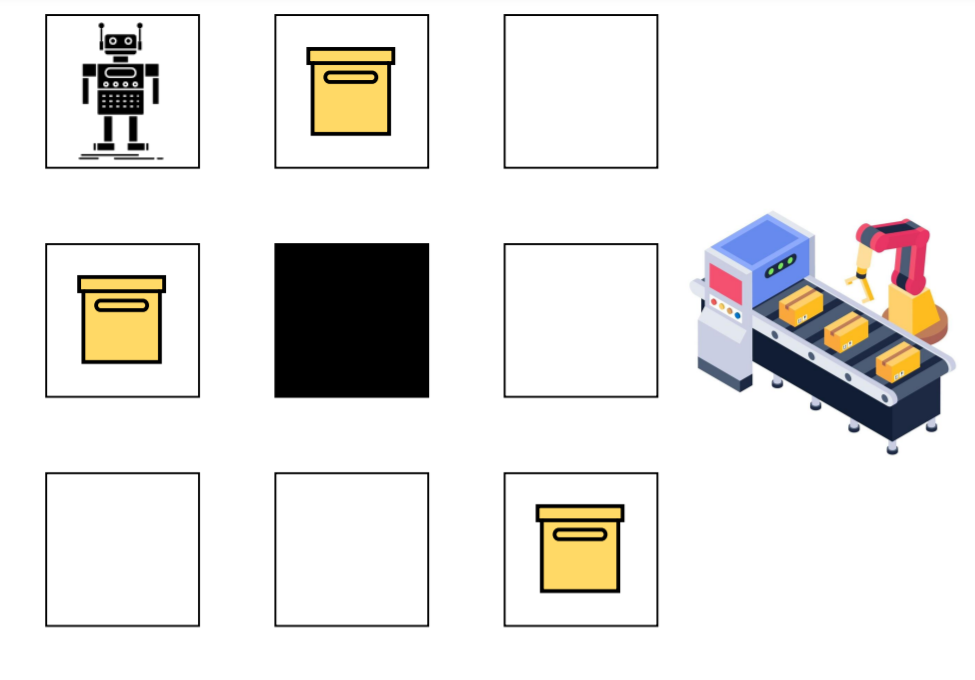</center>

En la imagen, el robot se encuentra en la posición (0,0). Las cajas se encuentran en (0,1), (1,0) y (2,2).<br>
La posición (1,1) está bloqueada, por lo tanto, el robot no puede pasar por ahí y tampoco habrán cajas ahí.<br>
El robot puede moverse a la izquierda, derecha, arriba y abajo. Además, **puede levantar como máximo una caja**.<br>
El robot debe llevar todas las cajas a la posición (1,2), **una a la vez**, donde deberá colocarlas en la cinta transportadora.<br>
El robot **solo puede moverse en sentido horario**.<br>
Cada posición puede tener el estado 'box' o 'free'.<br>
El robot y la caja pueden compartir una posición. De la misma manera con la cinta transportadora.




# Clase <b>Thing</b>

Esta clase genérica representa cualquier objeto físico que puede aparecer en un <b>Ambiente</b>. (No editar)  

In [2]:
class Thing(object):

    def is_alive(self):
        """Cosas 'vivas'deben retornar true."""
        return hasattr(self, 'alive') and self.alive

    def show_state(self):
        """Muestra el estado interno del agente. Subclases deben sobreescribir esto."""
        print("I don't know how to show_state.")

# Clase <b>Agent</b>

Un agente es una subclase de Thing con un slot obligatorio: <b>.program</b>, el cual almacena la función que implementa el <b>programa del agente</b>. Esta funcion debe tomar como argumento la <b>percepción</b> del agente y debe retornar una <b>acción</b>. La definición de Percepción y Acción depende del ambiente de trabajo (environment) donde el agente existe. El agente tambien puede tener el slot <b>.performance</b>, que mide el desempeño del agente en su ambiente.

In [9]:
import collections
import random

class Agent(Thing):

    def __init__(self, program=None):
        self.alive = True
        self.performance = 0
        self.busy = False
        assert isinstance(program, collections.abc.Callable)
        self.program = program

# Clase <b>Environment</b>

Esta clase abstracta representa un entorno de tareas. Clases de entornos especificos heredan de esta. En un entorno típicamente se necesitará implementar 2 cosas:
<b>percept</b>, que define la percepción que el agente ve; y
<b>execute_action</b>, que define los efectos de ejecutar una acción.
El entorno mantiene una lista de .things y .agents (el cual es un subconjunto de .things). Cada elemento de .things tiene un slot .location. (No editar)

In [4]:
class Environment(object):

    def __init__(self):
        self.things = []
        self.agents = []

    def thing_classes(self):
        return []  # List of classes that can go into environment

    def percept(self, agent):
        """Retorna la percepción que el agente 'agent' ve en este punto."""
        raise NotImplementedError

    def execute_action(self, agent, action):
        """El agente 'agent' ejecuta una acción 'action' en el entorno."""
        raise NotImplementedError

    def default_location(self, thing):
        """Localización por defecto para colocar una nueva cosa sin localización especificada."""
        return None

    def is_done(self):
        """Retorna True si no hay ningún agente vivo"""
        return not any(agent.is_alive() for agent in self.agents)

    def add_thing(self, thing, location=None):
        """Añade una cosa thing al entorno en la localización location.
           Si thing es un programa de agente, crea un nuevo agente con ese programa."""
        if not isinstance(thing, Thing):
            thing = Agent(thing)
        assert thing not in self.things, "No añade la misma cosa dos veces"
        thing.location = location if location is not None else self.default_location(thing)
        self.things.append(thing)
        if isinstance(thing, Agent):
            thing.performance = 0
            self.agents.append(thing)

    def step(self):
        """Ejecuta un paso del entorno (llama a los programas de los agentes, obtiene sus acciones y las ejecuta). """
        if not self.is_done():
            actions = []
            for agent in self.agents:
                if agent.alive:
                    actions.append(agent.program(self.percept(agent)))
                else:
                    actions.append("")
            for (agent, action) in zip(self.agents, actions):
                self.execute_action(agent, action)

    def run(self, steps=1000):
        """Ejecuta steps pasos en el entorno."""
        for step in range(steps):
            if self.is_done():
                return
            self.step()

# Clase <b>FactoryEnviroment</b>

Esta clase implementa el entorno del robot transportador.<br>
Cada una de estas posiciones puede tener el estado 'box' o 'free'.<br>
Un agente en este entorno percibe su localización, el estado de la misma y si se encuentra levantando una caja.

In [11]:
class FactoryEnviroment(Environment):

    def __init__(self):
        super().__init__()
        self.status = {(0,0): random.choice(['box', 'free']),
                       (0,1): random.choice(['box', 'free']),
                       (0,2): random.choice(['box', 'free']),
                       (1,0): random.choice(['box', 'free']),
                       (1,2): random.choice(['free']),
                       (2,0): random.choice(['box', 'free']),
                       (2,1): random.choice(['box', 'free']),
                       (2,2): random.choice(['box', 'free'])}

    def thing_classes(self):
        return [ReflexFactoryAgent]

    def percept(self, agent):
        """Percept es una tripla: (posición del agente, estado de la posición (box/free), flag de ocupacion del agente (True si esta cargando caja, False si no)."""
        return (agent.location, self.status[agent.location], agent.busy)

    def execute_action(self, agent, action):
        """Implementa el MAPA DE TRANSICIÓN: Cambia la posición del agente y/o el estado de la posición.
        Cada levantamiento (acción 'pick') en una localización 'box' provoca un aumento de desempeño en 5 unidades.
        Cada entrega (acción 'drop') en la cinta de transporte provoca un aumento de desempeño en 10 unidades.
        Cada movida efectiva Right, Left, Up o Down provoca una disminución de desempeño en 1 unidad """

        if action == 'pick':
            self.status[agent.location] = 'free'
            agent.performance += 5
            agent.busy = True
        elif action == 'drop':
            agent.performance += 10
            agent.busy = False
        else:
            actual_x, actual_y = agent.location  # agent.location es una tupla de coordenadas de la ubicacion del agente en el entorno

            ################################# COMPLETAR ###############################################
            # Debe ejecutar los movimientos y validar que las posiciones no excedan los límites.
            # Los movimientos posibles son: 'Right', 'Left', 'Up' y 'Down'

            if action == 'Left' and actual_y > 0:   # si movimiento es 'Left'
                actual_y -= 1

            elif  action == 'Right' and actual_y < 3:   # si movimiento es 'Right'
                actual_y += 1

            elif  action == 'Up' and actual_y > 0:   # si movimiento es 'Up'
                actual_x -= 1

            elif  action == 'Down' and actual_y < 3:   # si movimiento es 'Down'
                actual_x += 1

            ###########################################################################################

            # actualiza la posición del agente y penaliza el movimiento
            agent.location = actual_x, actual_y
            agent.performance -= 1

    def default_location(self, thing):
        """Devuelve una posicion aleatoria."""
        return random.choice([(0,0),(0,1),(0,2),(1,0),(2,0),(2,1),(2,2)])

# Agente Transportador de Cajas con Programa Reactivo Simple

Este agente es el agente transportador de 8 posiciones que usa un programa reactivo simple.<br>
Se debe implementar el programa de agente de tal manera que se logre transportar las cajas a la cinta transportadora.<br>
Se recibe la percepción que está formada por una dupla que representa la posición actual, el estado de la posición y si el agente carga o no una caja.

In [12]:
def ReflexFactoryAgent():

    def program(percept):
        location, status, busy = percept

        if status == 'box' and busy == False:
            return 'pick'
        elif location == (1,2) and busy == True:
            return 'drop'
        else:
            if location == (0,0) or location == (0,1):
                return 'Right'
            if location == (0,2) or location == (1,2):
                return 'Down'
            if location == (2,1) or location == (2,2):
                return 'Left'
            if location == (1,0) or location == (2,0):
                return 'Up'

    return Agent(program)

# Probando el Agente Reflexivo Simple en su Entorno

In [13]:
import warnings
warnings.filterwarnings('ignore')

"""Crea el entorno del robot transportador con 2 posiciones en estado 'box'"""
e = FactoryEnviroment()
e.status = {(0,0): 'free', (0,1): 'box',  (0,2): 'free', (1,0): 'box',
            (1,2): 'free', (2,0): 'free', (2,1): 'free', (2,2): 'box'}

"""Crea un agente reflexivo simple"""
a = ReflexFactoryAgent()

"""Añade el agente creado al entorno en posicion (0,0)"""
e.add_thing(a, location = (0,0))

# Imprime el estado inicial del ambiente y localización del agente
print("Estado Inicial del Ambiente:\n{}".format(e.status))
print("ReflexFactoryAgent está localizado en {} con desempeño = {}".format(a.location, a.performance))

"""Ejecuta el entorno 5 pasos y obtiene el desempeño del agente"""
e.run(5)

# Imprime el estado actual del ambiente, localización del agente y su desempeño
print("Estado del Ambiente despues de 5 pasos:\n{}".format(e.status))
print("ReflexFactoryAgent está localizado en {} con desempeño = {}".format(a.location, a.performance))


Estado Inicial del Ambiente:
{(0, 0): 'free', (0, 1): 'box', (0, 2): 'free', (1, 0): 'box', (1, 2): 'free', (2, 0): 'free', (2, 1): 'free', (2, 2): 'box'}
ReflexFactoryAgent está localizado en (0, 0) con desempeño = 0
Estado del Ambiente despues de 5 pasos:
{(0, 0): 'free', (0, 1): 'free', (0, 2): 'free', (1, 0): 'box', (1, 2): 'free', (2, 0): 'free', (2, 1): 'free', (2, 2): 'box'}
ReflexFactoryAgent está localizado en (1, 2) con desempeño = 12


## Cuestionario

1. Complete el código faltante en el ambiente FactoryEnviroment. No cambiar la medida de desempeño que tiene el ambiente, solo completar la lógica de movimientos.**(4 puntos)**

2. Analice el código del entorno y describa que acciones favorece el entorno de acuerdo a la medida de desempeño otorgada en agent.performance. **(4 puntos)**

3. ¿El agente puede tener un desempeño negativo? Si es así, plantee el escenario en que eso ocurriría. **(4 puntos)**

4. Plantee un programa de agente que maximize la medida de desempeño otorgada por el entorno. No es necesario colocar el código. **(4 puntos)**

5. Modifique el entorno (agregando validaciones) de tal manera que el programa de agente actual maximice la medida de desempeño **(4 puntos)**



In [ ]:
2. Las acciones que favorecen al entorno de acuerdo a las medidas de desempeño es el "pick" y el "drop" ya que estos suman en +5 y +10 respectivamente demostrando un avance
   en el objetivo que queremos lograr, mientras que moverse a un lugar donde no se recoja si se dropee resta -1 al desempeño, para asi poder cuantificar que un desempeño dependiendo de al cantidad de pasos que logra el programa.

3. Un caso que esto pueda ocurrir es que se plantee un numero de pasos donde el robot no tenga la posibilidad de recoger alguna caja, ya que al no poder recoger caja todos
    sus movimientos son negativos y no recibe el +5 de recoger.

4. Si pudiera plantear un programa de agente que maximize la medida de desempeño, podria modificar al robot y en este caso si podria moverse en sentido antihorario dependiendo de la ubicacion que encontro la caja.
    Asi se podria reducir los pasos innecesarios que hace el robot hasta entregar la caja. Ejemplo si el robot enuentra la caja en el (2, 2), podria moverse arriba para entregar la caja y no tener que hacer toda la vuelta que deberia
    si solo va en sentido horario

5. Se tendria que cambiar esta parte para maximizar el desempeño en FactoryEnvironment


        if self.status[agent.location] == 'box' and agent.busy == False:
            action == "pick"
            self.status[agent.location] = 'free'
            agent.performance += 5
            agent.busy = True
        elif self.status[agent.location] == (1,2) and agent.busy == True :
            action == 'drop':
            agent.performance += 10
            agent.busy = False
        else:
            .....